In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque , namedtuple


# creating the architecture for our neural network

In [2]:
class CustomNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, seed=42):
        super(CustomNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, output_dim)

    def forward(self, state):
        x = self.layer1(state)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        return self.output_layer(x)


# Training time

# Setting up the environment

In [3]:
import gymnasium as gym

env = gym.make('CartPole-v1')
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]


action_shape = env.action_space.shape
number_actions = env.action_space.n


# Initializing the hyperparameters

In [4]:
learning_rate = 7e-4
minibatch_size = 200
discount_factor = 0.999
replay_buffer_size = int(3e5)
interpolation_parameter = 1e-3

# Implementing Experience Replay

In [5]:
class ExperienceReplay:
    def __init__(self, capacity):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.capacity = capacity
        self.buffer = []

    def store(self, experience):
        self.buffer.append(experience)
        if len(self.buffer) > self.capacity:
            self.buffer.pop(0)

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, k=batch_size)
        states = torch.from_numpy(np.vstack([exp[0] for exp in batch if exp is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([exp[1] for exp in batch if exp is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([exp[2] for exp in batch if exp is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([exp[3] for exp in batch if exp is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([exp[4] for exp in batch if exp is not None]).astype(np.uint8)).float().to(self.device)
        return states, next_states, actions, rewards, dones


# Implementing the DQN Class

In [6]:
class Agent:
    def __init__(self, state_size, action_size, learning_rate, replay_buffer_size, minibatch_size, discount_factor, interpolation_parameter):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = CustomNetwork(state_size, action_size).to(self.device)
        self.target_qnetwork = CustomNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr=learning_rate)
        self.memory = ExperienceReplay(replay_buffer_size)
        self.t_step = 0
        self.minibatch_size = minibatch_size
        self.discount_factor = discount_factor
        self.interpolation_parameter = interpolation_parameter

    def step(self, state, action, reward, next_state, done):
        self.memory.store((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory.buffer) > self.minibatch_size:
                experiences = self.memory.sample_batch(self.minibatch_size)
                self.learn(experiences)

    def act(self, state, epsilon=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
            action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, next_states, actions, rewards, dones = experiences
        next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + self.discount_factor * next_q_targets * (1 - dones)
        q_expected = self.local_qnetwork(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_qnetwork, self.target_qnetwork)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.interpolation_parameter * local_param.data + (1.0 - self.interpolation_parameter) * target_param.data)


# Initializing the DQN agent

In [7]:
agent = Agent(
    state_size=state_size,
    action_size=number_actions,
    learning_rate=learning_rate,
    replay_buffer_size=replay_buffer_size,
    minibatch_size=minibatch_size,
    discount_factor=discount_factor,
    interpolation_parameter=interpolation_parameter
)


# Training the DQN agent

In [8]:
total_episodes = 2000
max_timesteps_per_episode = 500
initial_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995
epsilon = initial_epsilon
recent_scores = deque(maxlen=100)

for episode in range(1, total_episodes + 1):
    state, _ = env.reset()
    total_score = 0
    for timestep in range(max_timesteps_per_episode):
        action = agent.act(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        reward += next_state[0]                   # Adjusting reward if needed
        agent.step(state, action, reward, next_state, done)
        state = next_state
        total_score += reward
        if done:
            break
    recent_scores.append(total_score)
    epsilon = max(min_epsilon, epsilon_decay * epsilon)
    print(f'\rEpisode {episode}\tAverage Score: {np.mean(recent_scores):.2f}', end="")
    if episode % 100 == 0:
        print(f'\rEpisode {episode}\tAverage Score: {np.mean(recent_scores):.2f}')
    if np.mean(recent_scores) >= 500.0:
        print(f'\nEnvironment solved in {episode - 100} episodes!\tAverage Score: {np.mean(recent_scores):.2f}')
        torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
        break


Episode 100	Average Score: 20.11
Episode 200	Average Score: 13.19
Episode 300	Average Score: 12.32
Episode 400	Average Score: 10.57
Episode 500	Average Score: 11.51
Episode 600	Average Score: 13.74
Episode 700	Average Score: 19.33
Episode 800	Average Score: 40.65
Episode 900	Average Score: 44.41
Episode 1000	Average Score: 46.96
Episode 1100	Average Score: 50.40
Episode 1200	Average Score: 51.69
Episode 1300	Average Score: 52.88
Episode 1400	Average Score: 53.49
Episode 1500	Average Score: 55.13
Episode 1600	Average Score: 55.06
Episode 1700	Average Score: 58.96
Episode 1800	Average Score: 68.14
Episode 1900	Average Score: 109.49
Episode 2000	Average Score: 175.25


# Visualizing the Result

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os

def show_animation_of_model(agent, env_name, max_frames=1000):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []

    os.makedirs('generatedTestsforDQN', exist_ok=True)

    for frame_number in range(max_frames):
        if done:
            break
        frame = env.render()
        frames.append(frame)

        plt.imsave(f'generatedTestsforDQN/frame_{frame_number}.png', frame)

        action = agent.act(state)
        state, reward, done, _, _ = env.step(action)

    env.close()


    fig, ax = plt.subplots()
    ax.axis('off')
    img = ax.imshow(frames[0])

    def update(frame):
        img.set_array(frame)
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=True)
    plt.close(fig)  
    return HTML(ani.to_jshtml())

show_animation_of_model(agent, 'CartPole-v1')


# Implement and Training Double DDQNAgent

In [9]:
class DDQNAgent:
    def __init__(self, state_size, action_size, learning_rate, replay_buffer_size, minibatch_size, discount_factor, interpolation_parameter):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = CustomNetwork(state_size, action_size).to(self.device)
        self.target_qnetwork = CustomNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr=learning_rate)
        self.memory = ExperienceReplay(replay_buffer_size)
        self.t_step = 0
        self.minibatch_size = minibatch_size
        self.discount_factor = discount_factor
        self.interpolation_parameter = interpolation_parameter

    def step(self, state, action, reward, next_state, done):
        self.memory.store((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory.buffer) > self.minibatch_size:
                experiences = self.memory.sample_batch(self.minibatch_size)
                self.learn(experiences)

    def act(self, state, epsilon=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
            action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, next_states, actions, rewards, dones = experiences

        next_actions = self.local_qnetwork(next_states).detach().argmax(1).unsqueeze(1)
        next_q_targets = self.target_qnetwork(next_states).detach().gather(1, next_actions)

        q_targets = rewards + (self.discount_factor * next_q_targets * (1 - dones))
        q_expected = self.local_qnetwork(states).gather(1, actions)

        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.local_qnetwork, self.target_qnetwork)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.interpolation_parameter * local_param.data + (1.0 - self.interpolation_parameter) * target_param.data)


# initialize, create agent, and train DDQN

In [11]:
# Initialize the environment and agent
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n  # Add this line

# Hyperparameters
learning_rate = 7e-4
replay_buffer_size = int(3e5)
minibatch_size = 200
discount_factor = 0.999
interpolation_parameter = 1e-3


# Create agent
agent = DDQNAgent(state_size, action_size, learning_rate, replay_buffer_size, minibatch_size, discount_factor, interpolation_parameter)

# Training parameters
total_episodes = 2000
max_timesteps_per_episode = 500
initial_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995
epsilon = initial_epsilon
recent_scores = deque(maxlen=100)

# Training loop
for episode in range(1, total_episodes + 1):
    state, _ = env.reset()
    total_score = 0
    for timestep in range(max_timesteps_per_episode):
        action = agent.act(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        reward += next_state[0]  # Adjusting reward if needed
        agent.step(state, action, reward, next_state, done)
        state = next_state
        total_score += reward
        if done:
            break
    recent_scores.append(total_score)
    epsilon = max(min_epsilon, epsilon_decay * epsilon)
    print(f'\rEpisode {episode}\tAverage Score: {np.mean(recent_scores):.2f}', end="")
    if episode % 100 == 0:
        print(f'\rEpisode {episode}\tAverage Score: {np.mean(recent_scores):.2f}')
    if np.mean(recent_scores) >= 500.0:
        print(f'\nEnvironment solved in {episode - 100} episodes!\tAverage Score: {np.mean(recent_scores):.2f}')
        torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
        break

Episode 100	Average Score: 23.68
Episode 200	Average Score: 14.71
Episode 300	Average Score: 14.54
Episode 400	Average Score: 13.49
Episode 500	Average Score: 17.72
Episode 600	Average Score: 24.72
Episode 700	Average Score: 30.56
Episode 800	Average Score: 41.80
Episode 900	Average Score: 48.03
Episode 1000	Average Score: 51.22
Episode 1100	Average Score: 53.52
Episode 1200	Average Score: 53.26
Episode 1300	Average Score: 54.95
Episode 1400	Average Score: 57.82
Episode 1500	Average Score: 55.29
Episode 1600	Average Score: 59.11
Episode 1700	Average Score: 72.97
Episode 1800	Average Score: 123.82
Episode 1900	Average Score: 187.17
Episode 2000	Average Score: 205.80


# visualize DDQN

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os

def show_animation_of_model(agent, env_name, max_frames=1000):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []

    os.makedirs('generatedTestsforDDQN', exist_ok=True)  # Change folder name

    for frame_number in range(max_frames):
        if done:
            break
        frame = env.render()
        frames.append(frame)

        plt.imsave(f'generatedTestsforDDQN/frame_{frame_number}.png', frame)

        action = agent.act(state)
        state, reward, done, _, _ = env.step(action)

    env.close()

    fig, ax = plt.subplots()
    ax.axis('off')
    img = ax.imshow(frames[0])

    def update(frame):
        img.set_array(frame)
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=True)
    plt.close(fig)  
    return HTML(ani.to_jshtml())

show_animation_of_model(agent, 'CartPole-v1')


## q-value visualization

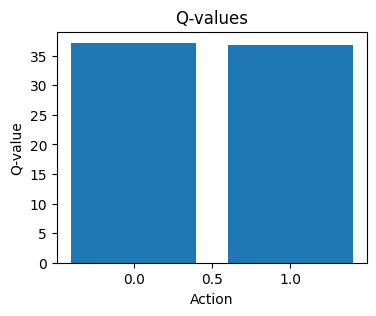

In [23]:
def plot_q_values(agent, state, title='Q-values'):
    state = torch.from_numpy(state).float().unsqueeze(0).to(agent.device)
    agent.local_qnetwork.eval()
    with torch.no_grad():
        q_values = agent.local_qnetwork(state)
    agent.local_qnetwork.train()
    
    q_values = q_values.cpu().numpy().flatten()
    plt.figure(figsize=(4, 3))
    plt.bar(range(agent.action_size), q_values)
    plt.xlabel('Action')
    plt.ylabel('Q-value')
    plt.title(title)
    plt.show()

# Example usage
state = env.reset()[0]
plot_q_values(agent, state)

In [33]:
## weights and gradients

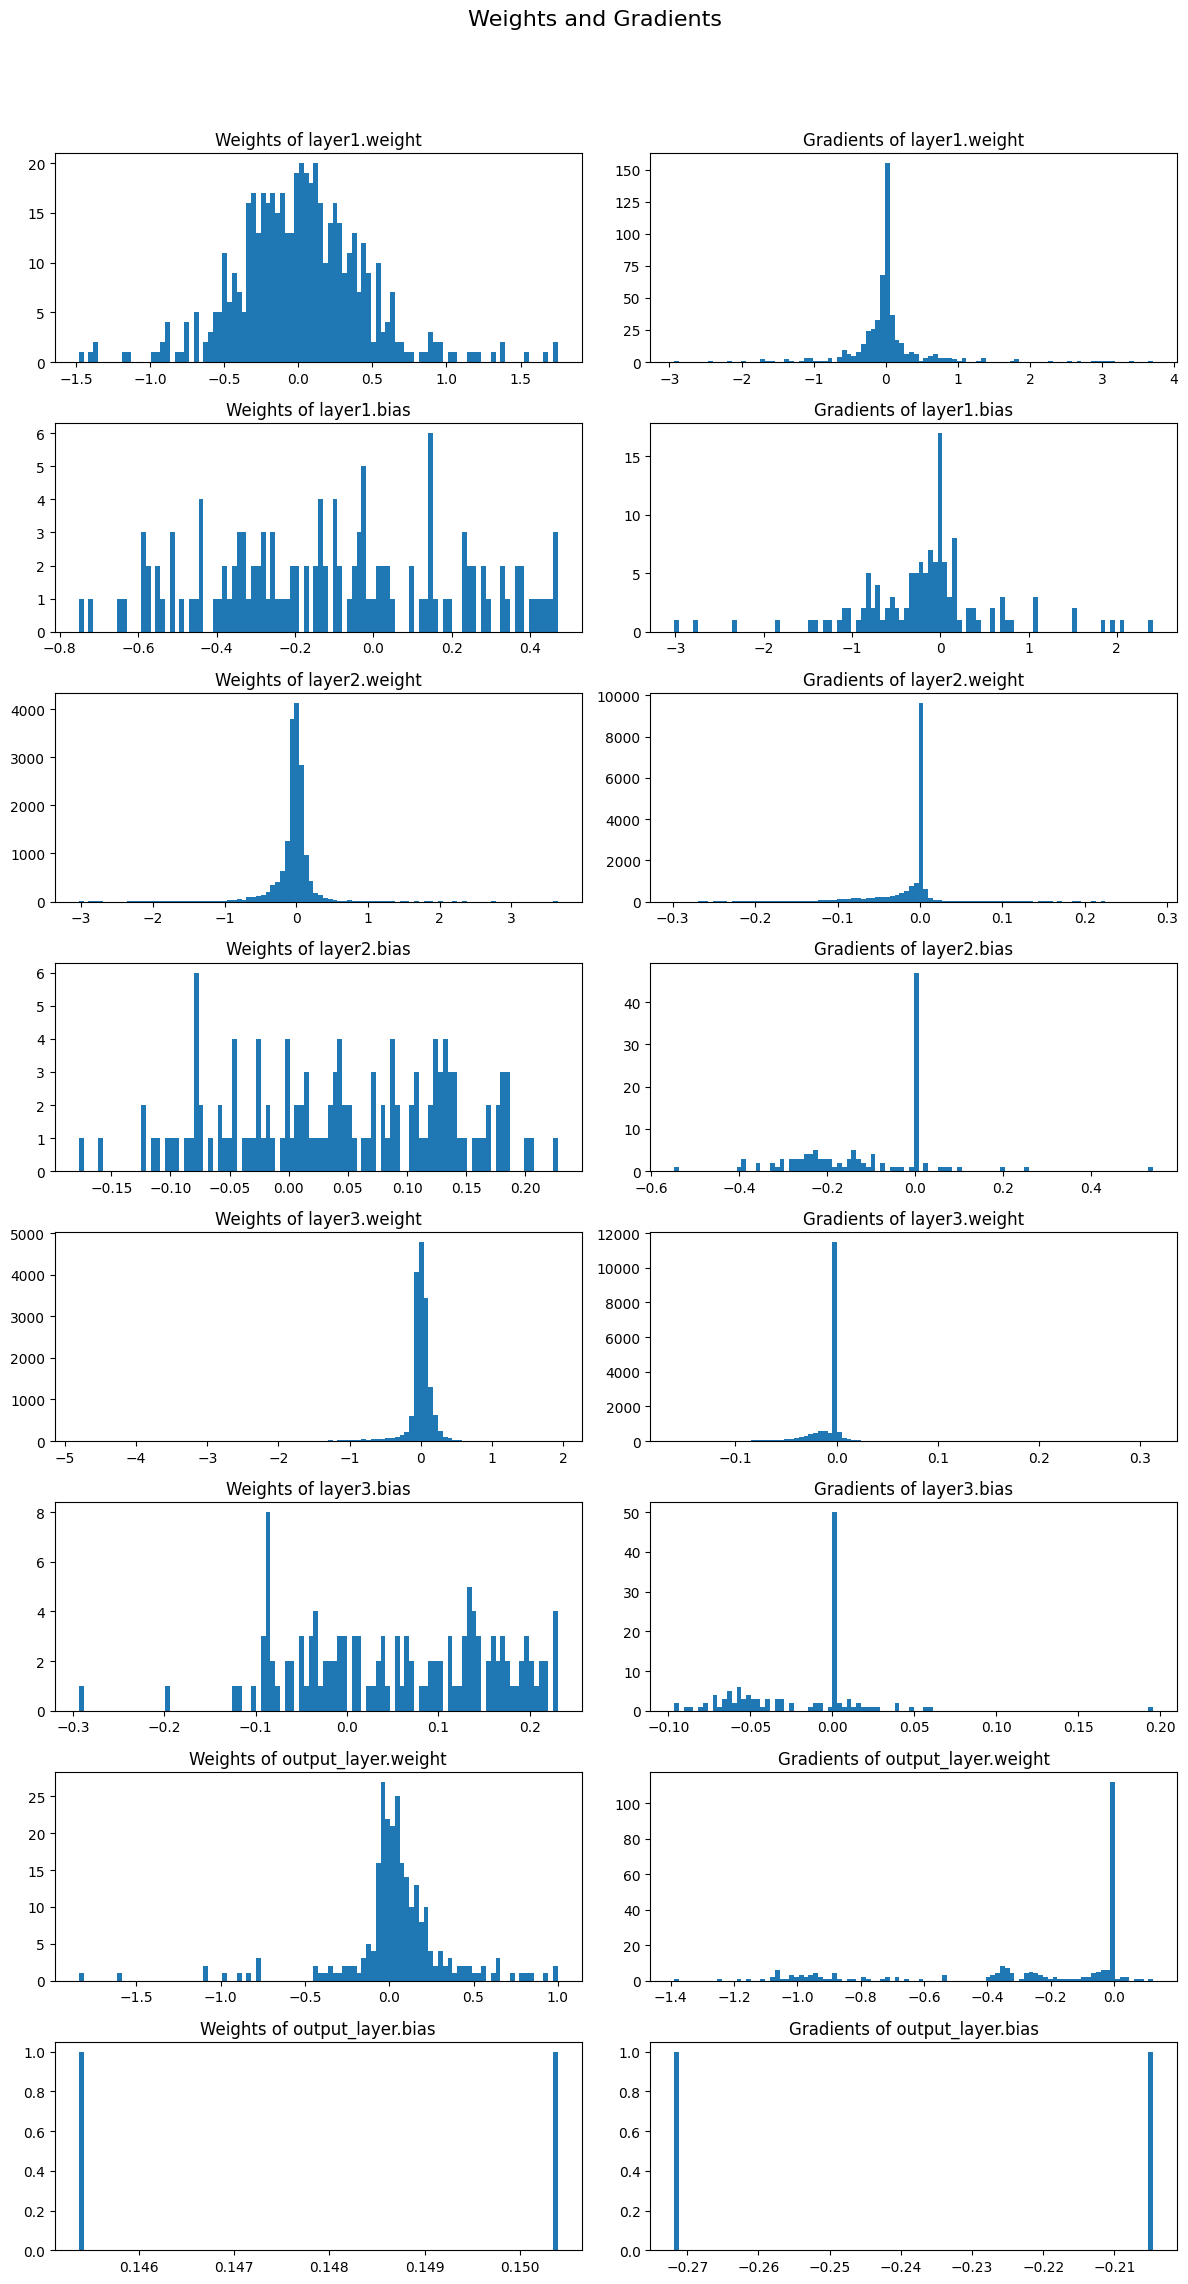

In [32]:
def plot_weights_and_gradients(agent):
    params = [(name, param) for name, param in agent.local_qnetwork.named_parameters() if param.requires_grad]
    num_params = len(params)
    
    fig, axes = plt.subplots(num_params, 2, figsize=(12, num_params * 3))
    fig.suptitle('Weights and Gradients', fontsize=16)
    
    for idx, (name, param) in enumerate(params):
        # plot weights
        ax_w = axes[idx, 0]
        ax_w.hist(param.data.cpu().numpy().flatten(), bins=100)
        ax_w.set_title(f'Weights of {name}')
        
        # plot gradients
        ax_g = axes[idx, 1]
        ax_g.hist(param.grad.cpu().numpy().flatten(), bins=100)
        ax_g.set_title(f'Gradients of {name}')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_weights_and_gradients(agent)


## inspect contents of replay buffer

In [19]:
def inspect_replay_buffer(agent, num_samples=5):
    sample_indices = random.sample(range(len(agent.memory.buffer)), num_samples)
    for idx in sample_indices:
        state, action, reward, next_state, done = agent.memory.buffer[idx]
        print(f'State: {state}, Action: {action}, Reward: {reward}, Next State: {next_state}, Done: {done}')

inspect_replay_buffer(agent)


State: [-0.95090204 -1.2711469  -0.20722008 -0.43504372], Action: 1, Reward: 0.02367502450942993, Next State: [-0.976325   -1.0737867  -0.21592095 -0.7852383 ], Done: True
State: [ 0.05333826  0.60982007 -0.08834615 -0.94550383], Action: 0, Reward: 1.0655347108840942, Next State: [ 0.06553466  0.415992   -0.10725623 -0.68183565], Done: False
State: [-1.1537362  -1.4460449  -0.08548084 -0.12271787], Action: 0, Reward: -0.1826571226119995, Next State: [-1.1826571  -1.6398448  -0.08793519  0.14181976], Done: False
State: [-1.4564674  -2.1914952  -0.01141185  0.720799  ], Action: 0, Reward: -0.5002971887588501, Next State: [-1.5002972  -2.3864574   0.00300413  1.0098684 ], Done: False
State: [ 1.4770467   1.8471601   0.05790571 -0.25707805], Action: 0, Reward: 2.5139899253845215, Next State: [1.5139899  1.6512613  0.05276415 0.05329243], Done: False
